<a href="https://colab.research.google.com/github/jasreman8/LLMs-For-RAGs-II/blob/main/RAG_Context_Compression_vs_Re_ranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Objectives

- Illustrate how to improve the generation process of RAG using:
    - Information Compression
    - Reranking


# Setup

 - openai for accessing various langchain models
 - importing tiktoken for tokenization (breaking text into tokens)
 - langchain library provides tools and abstractions that make it easier to work with language models and vector databases

!pip install -q openai==1.66.3 \
                tiktoken==0.9.0 \
                langchain==0.3.23 \
                langchain-chroma==0.2.2 \
                langchain-openai==0.3.9 \
                langchain-cohere>=0.6.0 \
                chromadb==0.6.3 \
                cohere>=6.0.0

In [2]:
import cohere, sys, pkgutil
print("cohere:", cohere.__version__, cohere.__file__)
import cohere.types as ct
print("has ChatResponse:", hasattr(ct, "ChatResponse"))

cohere: 5.20.1 /usr/local/lib/python3.12/dist-packages/cohere/__init__.py
has ChatResponse: False


In [3]:
import os
import chromadb # vector database that allows us to store and retrieve document embeddings

from openai import OpenAI # importing OpenAI to access their language models and various langchain components that will help us with ...
# (contd.) ... processing, retrieval, and the specialized techniques.

from langchain_core.documents import Document
from langchain_chroma import Chroma
from langchain_cohere import CohereRerank
from langchain_openai import OpenAIEmbeddings, ChatOpenAI

from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain.retrievers.document_compressors import CrossEncoderReranker

from google.colab import userdata

# Embeddings are numerical representations of text that capture the semantic meaning. It makes it possible to find similar documents.
# Embedding models convert text, images, or other data into dense numerical vectors (embeddings).

After running the above cell, you may need to restart the runtime to ensure the changes take effect.

In [4]:
os.environ['COHERE_API_KEY'] = userdata.get('cohere_api_key')
openai_api_key = userdata.get('my_api_key')

In [5]:
llm = ChatOpenAI(
    api_key=openai_api_key,
    model='gpt-4o-mini',
    temperature=0.4
)
# lower temperature makes the model more deterministic.

embedding_model = OpenAIEmbeddings(
    api_key=openai_api_key,
    model='text-embedding-3-small'
)
# Converts text into numerical vectors that will capture their meanings.

To illustrate the techniques of improving generation, let us set up an ephemeral Chroma database with a few documents.

In [6]:
chromadb_client = chromadb.EphemeralClient()
#Creating an ephermal client means that this database will only exist in memory and won't be persisted to the disk.

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given


In [7]:
documents = [
    Document(
        id=1,
        page_content="We design, develop, manufacture, sell and lease high-performance fully electric vehicles and energy generation and storage systems, and offer services related to our products. We generally sell our products directly to customers, and continue to grow our customer-facing infrastructure through a global network of vehicle showrooms and service centers, Mobile Service, body shops, Supercharger stations and Destination Chargers to accelerate the widespread adoption of our products. We emphasize performance, attractive styling and the safety of our users and workforce in the design and manufacture of our products and are continuing to develop full self-driving technology for improved safety. We also strive to lower the cost of ownership for our customers through continuous efforts to reduce manufacturing costs and by offering financial and other services tailored to our products.",
        metadata={"year": 2023, "section": "business"}
    ),
    Document(
        id=2,
        page_content="We have previously experienced and may in the future experience launch and production ramp delays for new products and features. For example, we encountered unanticipated supplier issues that led to delays during the initial ramp of our first Model X and experienced challenges with a supplier and with ramping full automation for certain of our initial Model 3 manufacturing processes. In addition, we may introduce in the future new or unique manufacturing processes and design features for our products. As we expand our vehicle offerings and global footprint, there is no guarantee that we will be able to successfully and timely introduce and scale such processes or features.",
        metadata={"year": 2023, "section": "risk_factors"}
    ),
    Document(
        id=3,
        page_content="We recognize the importance of assessing, identifying, and managing material risks associated with cybersecurity threats, as such term is defined in Item 106(a) of Regulation S-K. These risks include, among other things: operational risks, intellectual property theft, fraud, extortion, harm to employees or customers and violation of data privacy or security laws. Identifying and assessing cybersecurity risk is integrated into our overall risk management systems and processes. Cybersecurity risks related to our business, technical operations, privacy and compliance issues are identified and addressed through a multi-faceted approach including third party assessments, internal IT Audit, IT security, governance, risk and compliance reviews. To defend, detect and respond to cybersecurity incidents, we, among other things: conduct proactive privacy and cybersecurity reviews of systems and applications, audit applicable data policies, perform penetration testing using external third-party tools and techniques to test security controls, operate a bug bounty program to encourage proactive vulnerability reporting, conduct employee training, monitor emerging laws and regulations related to data protection and information security (including our consumer products) and implement appropriate changes.",
        metadata={"year": 2023, "section": "cyber_security"}
    ),
    Document(
        id=4,
        page_content="The automotive segment includes the design, development, manufacturing, sales and leasing of high-performance fully electric vehicles as well as sales of automotive regulatory credits. Additionally, the automotive segment also includes services and other, which includes non-warranty after- sales vehicle services and parts, sales of used vehicles, retail merchandise, paid Supercharging and vehicle insurance revenue. The energy generation and storage segment includes the design, manufacture, installation, sales and leasing of solar energy generation and energy storage products and related services and sales of solar energy systems incentives.",
        metadata={"year": 2022, "section": "business"}
    ),
    Document(
        id=5,
        page_content="Since the first quarter of 2020, there has been a worldwide impact from the COVID-19 pandemic. Government regulations and shifting social behaviors have, at times, limited or closed non-essential transportation, government functions, business activities and person-to-person interactions. Global trade conditions and consumer trends that originated during the pandemic continue to persist and may also have long-lasting adverse impact on us and our industries independently of the progress of the pandemic.",
        metadata={"year": 2022, "section": "risk_factors"}
    ),
    Document(
        id=6,
        page_content="The German Umweltbundesamt issued our subsidiary in Germany a notice and fine in the amount of 12 million euro alleging its non-compliance under applicable laws relating to market participation notifications and take-back obligations with respect to end-of-life battery products required thereunder. In response to Tesla’s objection, the German Umweltbundesamt issued Tesla a revised fine notice dated April 29, 2021 in which it reduced the original fine amount to 1.45 million euro. This is primarily relating to administrative requirements, but Tesla has continued to take back battery packs, and filed a new objection in June 2021. A hearing took place on November 24, 2022, and the parties reached a settlement which resulted in a further reduction of the fine to 600,000 euro. Both parties have waived their right to appeal.",
        metadata={"year": 2022, "section": "legal_proceedings"}
    )
]

We can now point our vector store to the Chroma client and add these documents to the vector store as in previous modules.

In [8]:
vectorstore = Chroma(
    collection_name="full_document_chunks",
    collection_metadata={"hnsw:space": "cosine"},
    embedding_function=embedding_model,
    client=chromadb_client
)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [9]:
chromadb_client.list_collections()

['full_document_chunks']

In [10]:
vectorstore.add_documents(
    documents=documents
)

['1', '2', '3', '4', '5', '6']

In [11]:
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={
        'k': 3
    }
)

# Information Compression

In this method, we prompt an LLM to extract specific portions of the context documents and exclude the rest of the context. This allows the LLM used for generation to focus on only the most relevant portions of the context and hence increase response quality.

Let us look at one such implementation from `langchain`.

In [12]:
compressor = LLMChainExtractor.from_llm(llm)
#The prompt instructs the model to extract parts of the context that are relevant to answering a specific question without editing the extracted content.

The prompt used by the compressor instantiated above is:

In [13]:
print(compressor.llm_chain.get_prompts()[0].template)

Given the following question and context, extract any part of the context *AS IS* that is relevant to answer the question. If none of the context is relevant return NO_OUTPUT. 

Remember, *DO NOT* edit the extracted parts of the context.

> Question: {question}
> Context:
>>>
{context}
>>>
Extracted relevant parts:


Let us now put through the context documents retrieved from the database through this compressor and observe the output.

In [14]:
user_input = "Any fines in 2022?"

In [15]:
relevant_document_chunks = retriever.invoke(user_input)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


In [16]:
len(relevant_document_chunks)

3

In [17]:
relevant_document_chunks[0]

Document(id='6', metadata={'section': 'legal_proceedings', 'year': 2022}, page_content='The German Umweltbundesamt issued our subsidiary in Germany a notice and fine in the amount of 12 million euro alleging its non-compliance under applicable laws relating to market participation notifications and take-back obligations with respect to end-of-life battery products required thereunder. In response to Tesla’s objection, the German Umweltbundesamt issued Tesla a revised fine notice dated April 29, 2021 in which it reduced the original fine amount to 1.45 million euro. This is primarily relating to administrative requirements, but Tesla has continued to take back battery packs, and filed a new objection in June 2021. A hearing took place on November 24, 2022, and the parties reached a settlement which resulted in a further reduction of the fine to 600,000 euro. Both parties have waived their right to appeal.')

In [18]:
context_list = [d.page_content for d in relevant_document_chunks]

We set up the compression retriever as a union of the base retriever (that extracts documents from the vector database) and the compressor (that trims retrieved documents).

In [19]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

In [20]:
compressed_docs = compression_retriever.invoke(user_input)

In [21]:
len(compressed_docs)

1

In [22]:
for compressed_doc in compressed_docs:
    print(compressed_doc.page_content)

The German Umweltbundesamt issued our subsidiary in Germany a notice and fine in the amount of 12 million euro alleging its non-compliance under applicable laws relating to market participation notifications and take-back obligations with respect to end-of-life battery products required thereunder. In response to Tesla’s objection, the German Umweltbundesamt issued Tesla a revised fine notice dated April 29, 2021 in which it reduced the original fine amount to 1.45 million euro. A hearing took place on November 24, 2022, and the parties reached a settlement which resulted in a further reduction of the fine to 600,000 euro.


The outputs above show that three documents were initially retrieved from the vector database as relevant to the user's query. However, after processing through the compressor, only one document remains. Additionally, the retained document has been refined to remove any information that is not directly relevant to the user's query.

# Reranking

In this method, retrieved documents are reranked in the order of relevance to the user query. It is common practise to retrieve a larger set of documents, and choose the top-n documents that are most relevant to the query after reranking.

Let us look at an implementation of this method using the reranking API exposed by Cohere. Cohere offers a restricted free-tier on its re-ranking models.

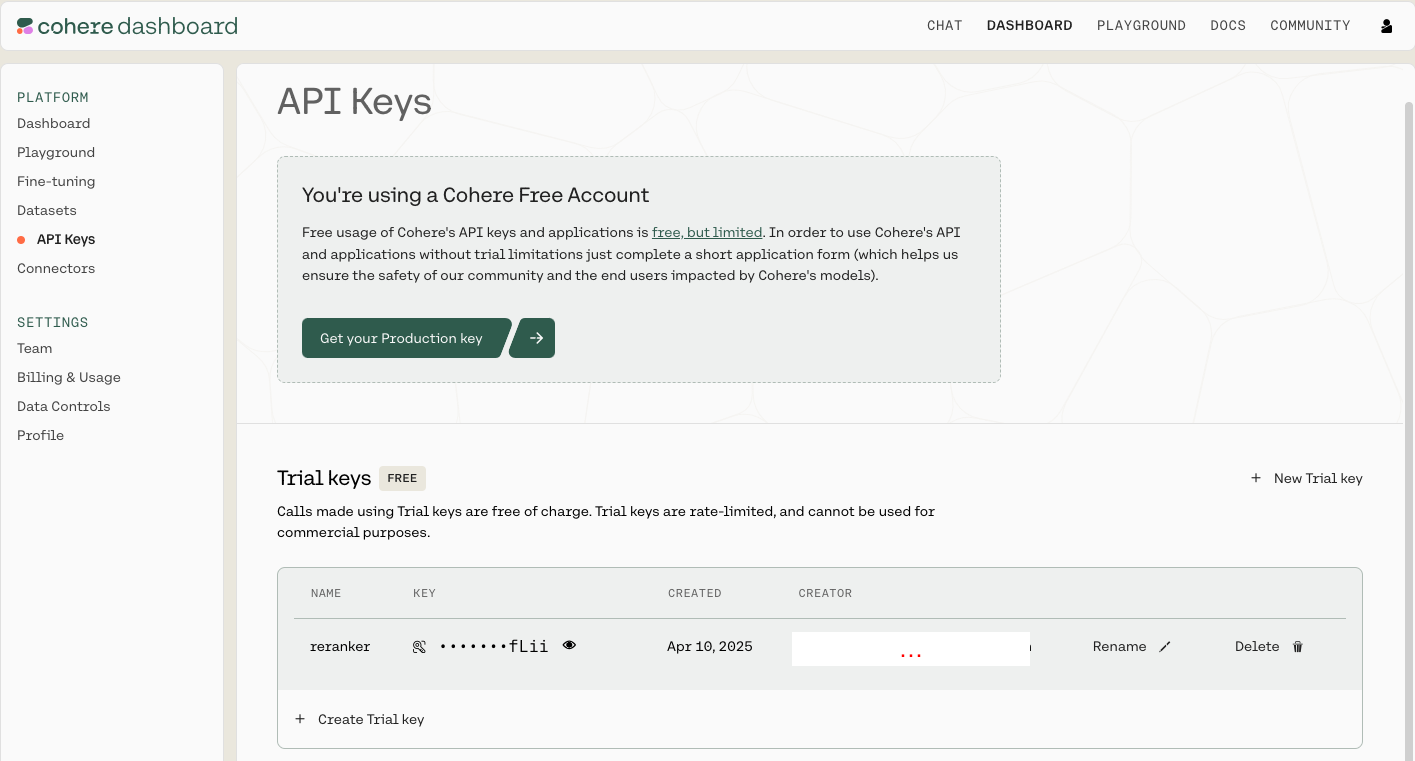

Let us now assemble a retriever that extracts 5 relevant documents for each user query.

In [23]:
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={
        'k': 5
    }
)

Let us now set up a reranker that reranks these documents and picks the top 3 most relevant ones.

In [24]:
reranker = CohereRerank(model="rerank-v3.5", top_n=3)

In [25]:
user_input = "Any fines in 2022?"

In [26]:
relevant_document_chunks = retriever.invoke(user_input)

In [27]:
context_list = [d.page_content for d in relevant_document_chunks]

We set up the reranker as a union of the base retriever (that extracts relevant documents from the vector database) and the compressor (that reranks and chooses a subset of these documents).

In [28]:
reranker_retriever = ContextualCompressionRetriever(
    base_compressor=reranker, base_retriever=retriever
)

In [29]:
reranked_docs = reranker_retriever.invoke(user_input)

In [30]:
context_list[0]

'The German Umweltbundesamt issued our subsidiary in Germany a notice and fine in the amount of 12 million euro alleging its non-compliance under applicable laws relating to market participation notifications and take-back obligations with respect to end-of-life battery products required thereunder. In response to Tesla’s objection, the German Umweltbundesamt issued Tesla a revised fine notice dated April 29, 2021 in which it reduced the original fine amount to 1.45 million euro. This is primarily relating to administrative requirements, but Tesla has continued to take back battery packs, and filed a new objection in June 2021. A hearing took place on November 24, 2022, and the parties reached a settlement which resulted in a further reduction of the fine to 600,000 euro. Both parties have waived their right to appeal.'

In [31]:
reranked_docs[0]

Document(metadata={'section': 'legal_proceedings', 'year': 2022, 'relevance_score': 0.13538086}, page_content='The German Umweltbundesamt issued our subsidiary in Germany a notice and fine in the amount of 12 million euro alleging its non-compliance under applicable laws relating to market participation notifications and take-back obligations with respect to end-of-life battery products required thereunder. In response to Tesla’s objection, the German Umweltbundesamt issued Tesla a revised fine notice dated April 29, 2021 in which it reduced the original fine amount to 1.45 million euro. This is primarily relating to administrative requirements, but Tesla has continued to take back battery packs, and filed a new objection in June 2021. A hearing took place on November 24, 2022, and the parties reached a settlement which resulted in a further reduction of the fine to 600,000 euro. Both parties have waived their right to appeal.')

We can also look at how many documents changed order once the reranking was executed like so:

In [32]:
for i in range(len(reranked_docs)):
    if reranked_docs[i].page_content == context_list[i]:
        continue
    else:
        print(f"Document at rank: {i} after reranking differs from the original order")

Document at rank: 1 after reranking differs from the original order
Document at rank: 2 after reranking differs from the original order
